In [ ]:
import os
import numpy as np
import scipy
from functools import partial

import datetime, time

from matplotlib import pyplot as plt

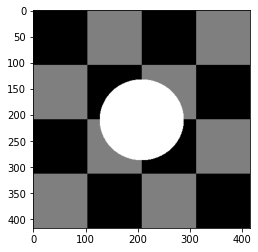

In [46]:
plt.imshow(arr[...,0], 'gray')

In [695]:
np.unique(arr) / 255.

array([0.        , 0.49803922, 1.        ])

initial image


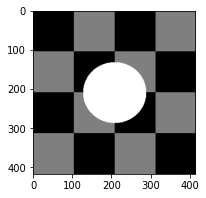

In [719]:
path = '../../../test1.bmp'
arr = plt.imread(path)[...,0]
labels = np.array(arr / 127, dtype=int)
x_arr = arr / 255.
print ("initial image")
plt.imshow(x_arr, cmap='gray');

In [697]:
def add_noise(x, sigma):
    noise = np.random.normal(0, sigma, x.shape)
    return x + noise

In [698]:
def pdf_of_normal(x, mean, var):
    return (1/np.sqrt(2 *  np.pi * var))*np.exp(-((x-mean)**2)/(2*var))

${\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}}$

In [172]:
def gaussian_log_density(x, mean, log_var):
    """Computes the log density of a Gaussian."""
    log2pi = np.log(2. * np.pi)
    inv_sigma = np.exp(-log_var)
    delta = (x - mean)
    return - 0.5 * (delta**2 * inv_sigma + log_var + log2pi)

def gaussian_density(x, mean, var):
    """Computes the density of a Gaussian."""
    norm_const = 1. / np.sqrt(2 * np.pi)
    inv_sigma = 1. / np.sqrt(var)
    delta_sq = (x - mean)**2
    return norm_const * inv_sigma * np.exp(-delta_sq / (2 * var))

In [699]:
label_to_value = {
    0: 0,
    1: 127,
    2: 255
}
value_to_label = {v: k for k, v in label_to_value.items()}

In [700]:
def get_dims(x):
    """Returns the (b)atch, (h)eight, (w)idth, and (d)epth of an array/tensor."""
    ndim = len(x.shape) # in the case of a tensor
    if ndim == 2:
        return (0, *x.shape, 0)
    elif ndim == 4:
        return x.shape
    else:
        raise ValueError(f"Expected 2 or 4 dims, got {x.ndim}")

In [701]:
def naive_bayes_learning(arr, noisy_arr, labels):
    class_info = []
    number_of_pixels = arr.size
    for cls in [0,1,2]:
        tmp = []
        for i in range(0, len(arr)):
            for j in range(0, len(arr[0])):
                if (labels[i][j]==cls):
                    tmp.append(noisy_arr[i][j])
        tmp = np.asarray(tmp)
        class_mean = np.mean(tmp)
        class_var = np.var(tmp)
        class_freq = len(tmp)
        class_probabilty = class_freq/number_of_pixels
        class_info.append([class_probabilty, class_mean, class_var])
    return class_info

def pdf_of_normal(x, mean, var):
    return (1/np.sqrt(2 *  np.pi * var))*np.exp(-((x-mean)**2)/(2*var))

def naive_bayes_predict (arr, class_info, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    class_color = [0,127,255]
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index)>0 and len(correct_arr)>0 and fixed_pixels_index[i][j]==1):
                predict_array[i][j]=correct_arr[i][j]
                continue
            max_probabilty = 0
            best_class = -1
            val = arr[i][j]
            for cls_index in range(len(class_info)):
                cls_p =  class_info[cls_index][0]
                mean =  class_info[cls_index][1]
                var = class_info[cls_index][2]
                pos =pdf_of_normal(val, mean, var)
                cls_posterior = cls_p * pos

                if (cls_posterior > max_probabilty):
                    max_probabilty = cls_posterior
                    best_class = cls_index
            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

Noisy Image with var 0


/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


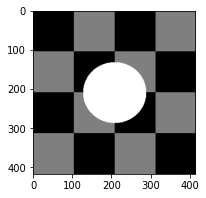

Naive Bayes Classifier Labels


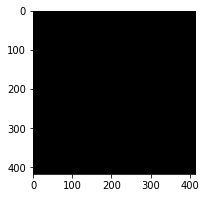

In [720]:

# variance_list = [100, 1000, 20000]
var_list = [0, 0.1, 1., 2., 5.]
for var in var_list:
    noisy_arr = add_noise(x_arr, var)
    nb = NaiveBayes(3).fit(noisy_arr, labels)
    y_pred = nb.predict(noisy_arr)
    print ("Noisy Image with var", var)
    plt.imshow(noisy_arr, cmap='gray')
    plt.show()
    print ("Naive Bayes Classifier Labels")
    plt.imshow(y_pred, cmap='gray')
    plt.show()
    break

Noisy Image with var 1.0


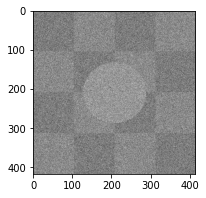

Naive Bayes Classifier Labels


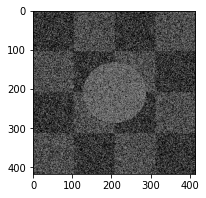

In [1291]:

variance_list = [100, 1000, 20000]
var_list = [1.,]
for var in var_list:
    x_noise = add_noise(x_arr, var)
    cls_info = naive_bayes_learning(x_arr, x_noise, labels)
    nb = NaiveBayes(3).fit(x_noise, labels)
    prediciton_array = naive_bayes_predict(x_noise, cls_info)
    print ("Noisy Image with var", var)
    plt.imshow(x_noise, cmap='gray')
    plt.show()
    print ("Naive Bayes Classifier Labels")
    plt.imshow(prediciton_array, cmap='gray')
    plt.show()
    break

In [1322]:
def distance (x,y):
    a = x-y
    a = a*a
    return np.sqrt(np.sum(a))

def differnce(a,b):
    if (a==b):
        return -1
    else:
        return 1
    
def initial_energy_function(initial_w, pixels, betha, cls_info, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            mean = cls_info[int (w[i][j])][1]
            var =  cls_info[int (w[i][j])][2]
            energy += np.log(np.sqrt(2*np.pi*var)) 
            energy += ((pixels[i][j]-mean)**2)/(2*var)
            for a,b in neighbors_indices:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += betha * differnce(w[i][j], w[a][b])
    return energy

In [1394]:
def exponential_schedule(step_number, current_t, initial_temp,  constant=0.99):
    return current_t*constant

def logarithmical_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * np.log(1+step_number))

def linear_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * step_number)

def delta_enegry(w, index, betha, new_value, neighbors_indices, pixels, cls_info):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    mean = cls_info[int(w[i][j])][1]
    var =  cls_info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2*np.pi*var)) 
    initial_energy += ((pixels[i][j]-mean)**2)/(2*var)
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * differnce(w[i][j], w[a][b])
    
    new_energy = 0
    mean = cls_info[new_value][1]
    var =  cls_info[new_value][2]
    new_energy += np.log(np.sqrt(2*np.pi*var)) 
    new_energy += ((pixels[i][j]-mean)**2)/(2*var)
    # print("/////// \n first enegry", new_energy)

    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * differnce(new_value, w[a][b])

    # print ("END energy", new_energy)
    return new_energy - initial_energy

In [1144]:
def compute_energy(x, mu, var):
    return np.sum(np.log(np.sqrt(2. * np.pi * var)) + ((x - mu)**2 / (2. * var)))

In [1405]:
DEFAULT_NEIGHBORS = np.array([
    [0,  1., 0 ],
    [1., 0,  1.],
    [0,  1., 0 ]
])

def default_rule(x):
    rule = {True: -1, False: 1}
    return rule.get(x)


class NaiveBayes:
    
    def __init__(self, num_classes, priors=None):
        self.num_classes = num_classes
        self.params = {}
        # should these mean of each feature per class tho?
        # i.e. mean of each object per symbol/color???
        self.mu = np.zeros(self.num_classes, np.float64)
        self.sigma = np.zeros(self.num_classes, np.float64)
        self.freq = np.zeros(self.num_classes, np.int64)
        self.priors = np.zeros(self.num_classes, np.float64)
        
    def fit(self, X, y):
        self._compute_priors(X, y)
        return self
    
    def _compute_priors(self, X, y):
        size = X.size
        self.xc = []
        for c in range(self.num_classes):
            X_c = X[np.where(y == c)]
            self.xc.append(X_c)
            self.mu[c] = np.mean(X_c)
            self.sigma[c] = np.var(X_c)
            self.freq[c] = len(X_c)
            self.priors[c] = self.freq[c] / size
            
        self.params = {
            'mu': self.mu,
            'sigma': self.sigma,
            'freq': self.freq,
            'priors': self.priors
        }
        
    def _update_priors(self):
        pass
    
    def _log_likelihoods(self, X):
        lls = []
        for c in range(self.num_classes):
            px_cond_c = gaussian_density(X, self.mu[c], self.sigma[c])
            pc_cond_x = self.priors[c] * px_cond_c
            lls.append(pc_cond_x)
        return lls
        
    def predict(self, X):
        return np.argmax(self._log_likelihoods(X), axis=0)


class MRF(NaiveBayes):
    """
    
    https://www2.isye.gatech.edu/~brani/isyebayes/bank/handout16.pdf
    Gibbs
    -----
        P(X) = 1/Z * exp( U(X)/T )
    
    Z is a normalizing constant called the partition function, 
    T is a constant called the temperature 
    U is the energy function. The energy U(X) = sum_c( V(X) )
        is a sum of clique potentials V_c over all possible cliques c ∈ C.
        The value of depends on the local configuration on the clique c. 
    """
    
    def __init__(self, 
                 num_classes,
                 scheduler=None,
                 beta=100,
                 start_temperature=1000,
                 temperature_factor=0.99,
                 neighbors=None,
                 delta_rule=None,
                 delta_th=10):
        super(MRF, self).__init__(num_classes)
        self.scheduler = scheduler
        self.beta = beta
        self.start_temperature = start_temperature
        self.temperature_factor = temperature_factor
        if delta_rule is None:
            self.delta_rule = default_rule
        else:
            self.delta_rule = delta_rule
        if neighbors is None:
            self.neighbors = DEFAULT_NEIGHBORS
        else:
            self.neighbors = neighbors
        self.delta_th = delta_th
        
        self.nh_, self.nw_ = self.neighbors.shape
        if self.nh_ % 2 == 0 or self.nw_ % 2 == 0:
            raise ValueError('Expected `neighbors` to have odd dimensions, '
                             f'got {(nh, nw)}')
        self.nh_pad = self.nh_ // 2
        self.nw_pad = self.nw_ // 2
                
        self._nbh_indices = np.where(self.neighbors > 0)
        self._nbh_weights = self.neighbors[self._nbh_indices]
        self.delta_f = np.vectorize(self.delta_rule)

    def fit(self, X, y, num_steps=100):
        b, h, w, d = get_dims(X)
        self._compute_priors(X, y)
        self._class_mu = {i: v for i, v in enumerate(self.mu)}
        self._class_sigma = {i: v for i, v in enumerate(self.sigma)}
        X_prior = np.argmax(self._log_likelihoods(X), axis=0)
#         X_post, X_changed = self._simiulated_annealing(X, X_prior, num_steps)
        return X_post, X_changed
    
    def predict(self, X):
        pass
    
    def _delta_energy(self, X, X_prior, index, new_class):
        
        c = X_prior[index]
        current_energy = compute_energy(X[index], self.mu[c], self.sigma[c])
        current_energy += self._nbh_energy(X_prior, index)
        
        new_energy = compute_energy(X[index], self.mu[new_class], self.sigma[new_class])
        new_energy += self._nbh_energy(X_prior, index, value=new_class)
        
        return new_energy - current_energy
    
    def _nbh_energy(self, X, index, value=None):
        i, j = index
        value = value if value is not None else X[i, j]
        h_slice = np.array([max(i - self.nh_pad, 0), 
                            min(i + self.nh_pad + 1, X.shape[0])])
        w_slice = np.array([max(j - self.nw_pad, 0), 
                            min(j + self.nw_pad + 1, X.shape[1])])
        x_clique = X[(slice(*h_slice), slice(*w_slice))]
        nbh = self.neighbors[(slice(*h_slice - i + self.nw_pad), 
                              slice(*w_slice - j + self.nh_pad))]
        return self.beta * np.sum(self.delta_f(x_clique == value) * nbh)
    
    def _total_energy(self, X, X_prior):
        b, h, w, d = get_dims(X)
        
        # matrices of mean and variance in place of classes
        X_mean = np.vectorize(self._class_mu.__getitem__)(X_prior)
        X_var = np.vectorize(self._class_sigma.__getitem__)(X_prior)
        energy = compute_energy(X, X_mean, X_var)
        
        # accumulate energy using the delta rule of each values neighbors
        nbh_energy = [
            self._nbh_energy(X_prior, (i,j)) 
            for i in range(h) 
            for j in range(w)
        ]
        return energy + np.sum(nbh_energy)
    
    def _simiulated_annealing(self, X, X_prior, num_steps):
        b, h, w, d = get_dims(X)
        
        energy = self._total_energy(X, X_prior)
        x_changed = np.zeros((h, w))
        print(f'current: {energy}')
        temperature = self.start_temperature
        self.deltas = []
        self.idx = []
        self.new_classes = []
        self.energy = [energy]
        self.changed = []
        
        for step in range(num_steps):
#             if step % 500 == 0:
#                 print(step)
            i = np.random.choice(range(h))
            j = np.random.choice(range(w))
            
            new_class = np.random.choice(
                [c for c in range(self.num_classes) if c != X_prior[i,j]]
            )
            delta = self._delta_energy(X, X_prior, (i,j), new_class)
            self.idx.append((i,j))
            self.new_classes.append(new_class)
            self.deltas.append(delta)

            if delta <= 0:
                X_prior[i,j] = new_class
                energy += delta
                x_changed[i, j] += 1
                self.changed.append(1)
            else:
                # where did this come from / come back to this
                if delta / temperature > self.delta_th:
                    # don't update
                    k = 0
                else:
                    # change probabilistically
                    k = np.exp(-delta / temperature)

                if np.random.uniform() < k:
                    X_prior[i,j] = new_class
                    energy += delta
                    x_changed[i,j] += 1
                    self.changed.append(1)
                else:
                    self.changed.append(0)
                   
            self.energy.append(energy)
            if self.scheduler is not None:
                temperature = self.scheduler(step, 
                                             temperature, 
                                             self.start_temperature, 
                                             self.temperature_factor)
        return X_prior, x_changed

In [866]:
model.start_temperature

1.0

In [871]:
np.exp(-.1)

0.9048374180359595

In [870]:
np.exp(-model.deltas[0])

0.6428401012725502

In [872]:
d = np.array(model.deltas[:100])

In [875]:
import seaborn as sns

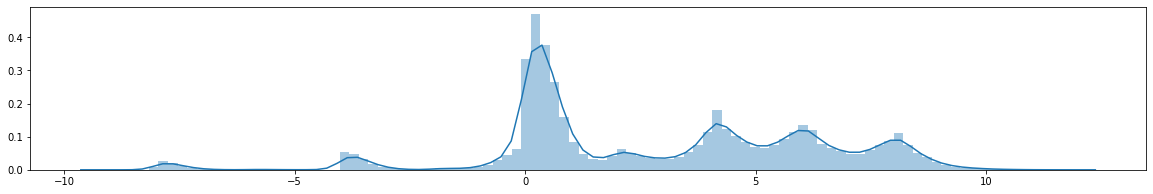

In [880]:
sns.distplot(model.deltas, bins=100)

(array([ 15770.,   1196.,  33938.,   9516., 387453.,  83194., 194418.,
        169810., 101874.,   2831.]),
 array([-8.98662298, -6.91594283, -4.84526268, -2.77458253, -0.70390237,
         1.36677778,  3.43745793,  5.50813808,  7.57881823,  9.64949838,
        11.72017854]),
 <a list of 10 Patch objects>)

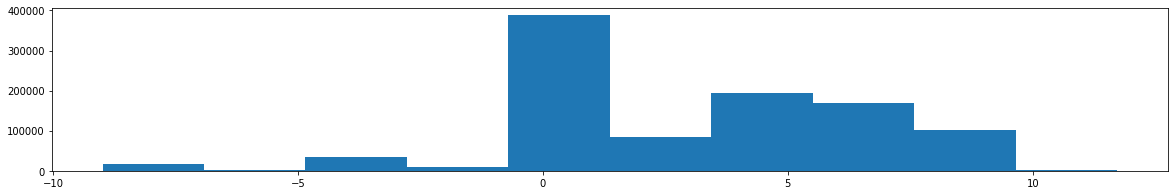

In [867]:
plt.hist(model.deltas)

In [865]:
idx = 0
ij = model.idx[idx]
print(f'label: {labels[ij]}')
print(f'delta: {model.deltas[idx]}')
print(f'new class: {model.new_classes[idx]}')
print(f'changed       : {model.changed[idx]}')
print(f'total changes : {int(x_changed[ij])}')

label: 0
delta: 0.44185926176200097
new class: 0
changed       : 1
total changes : 2


In [917]:
def gaussian_density(x, mean, var):
    """Computes the density of a Gaussian."""
    norm_const = 1. / np.sqrt(2 * np.pi + 1e-7)
    inv_sigma = 1. / np.sqrt(var + 1e-7)
    delta_sq = (x - mean)**2
    return norm_const * inv_sigma * np.exp(-delta_sq / (2 * var + 1e-7))

Noisy Image with var 0


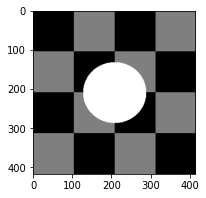

Naive Bayes Classifier Labels


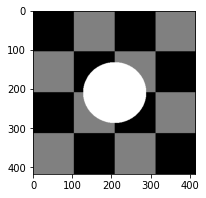

Noisy Image with var 0.1


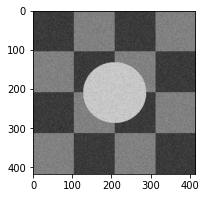

Naive Bayes Classifier Labels


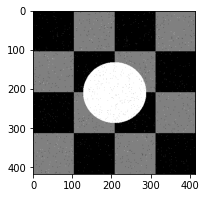

Noisy Image with var 1.0


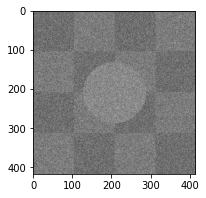

Naive Bayes Classifier Labels


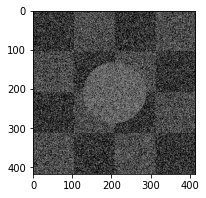

Noisy Image with var 2.0


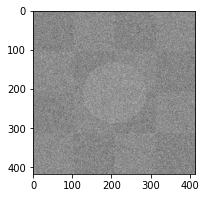

Naive Bayes Classifier Labels


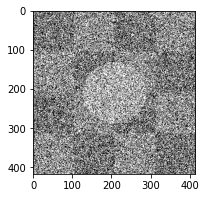

Noisy Image with var 5.0


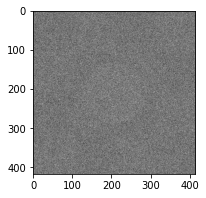

Naive Bayes Classifier Labels


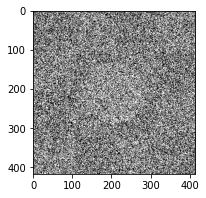

In [756]:
# variance_list = [100, 1000, 20000]
var_list = [0, 0.1, 1., 2., 5.]
for var in var_list:
    x_noise = add_noise(x_arr, var)
    nb = NaiveBayes(3).fit(x_noise, labels)
    y_pred = nb.predict(x_noise)
    print ("Noisy Image with var", var)
    plt.imshow(x_noise, cmap='gray')
    plt.show()
    print ("Naive Bayes Classifier Labels")
    plt.imshow(y_pred, cmap='gray')
    plt.show()


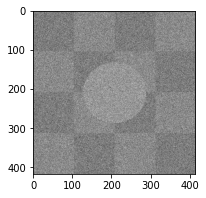

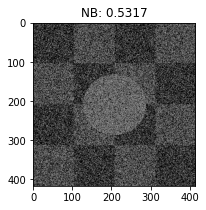

current: 180723.4163827758
0:00:08.660150


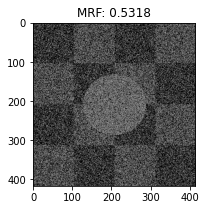

In [1390]:
# x_noise = add_noise(x_arr, 1.)
plt.imshow(x_noise, 'gray')
plt.show();

nb = NaiveBayes(3)
nb.fit(x_noise, labels)
pred_nb = nb.predict(x_noise)
y_pred = np.vectorize(label_to_value.__getitem__)(pred_nb)
plt.imshow(y_pred/255., 'gray')
plt.title(f'NB: {np.mean(y_pred == arr):.4f}')
plt.show();

model = MRF(3, beta=1, start_temperature=1., scheduler=exponential_schedule)
start_dt = time.time()
x_post, x_changed = model.fit(x_noise, labels, 100)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)
y_pred = np.vectorize(label_to_value.__getitem__)(x_post)
plt.imshow(y_pred/255., 'gray')
plt.title(f'MRF: {np.mean(y_pred == arr):.4f}')
plt.show();

In [1161]:
neighbors_indices=[[0,1],[0,-1],[1,0],[-1,0]]

In [1298]:
model._delta_energy(x_noise, X_prior, (10,10), new_class=0, )

-0.16843761578860406

In [1331]:
tmp

2.0

In [1345]:
cls_info

[[0.44231024818699255, 0.002042486111599932, 1.0095675585667354],
 [0.44469677270232005, 0.4972366467330664, 0.9954621861257301],
 [0.11299297911068736, 1.0015261191754394, 1.0071722131887688]]

In [1382]:
model._nbh_energy(X_prior, index)

1
[[0 1 0]
 [0 1 0]
 [0 0 1]]
[[ 1 -1  1]
 [ 1 -1  1]
 [ 1  1 -1]]
[[ 0. -1.  0.]
 [ 1. -0.  1.]
 [ 0.  1. -0.]]


2.0

In [1383]:
model._nbh_energy(X_prior, index, value=new_class)

1
[[0 1 0]
 [0 1 0]
 [0 0 1]]
[[ 1 -1  1]
 [ 1 -1  1]
 [ 1  1 -1]]
[[ 0. -1.  0.]
 [ 1. -0.  1.]
 [ 0.  1. -0.]]


2.0

In [1388]:
index = (10,10)
new_class = 0
c = X_prior[index]
current_energy = compute_energy(x_noise[index], cls_info[c][1], cls_info[c][2])
current_energy1 = current_energy + model._nbh_energy(X_prior, index)

new_energy = compute_energy(x_noise[index], cls_info[new_class][1], cls_info[new_class][2])
tmp = model._nbh_energy(X_prior, index, value=new_class)
new_energy1 = new_energy + tmp

new_energy1 - current_energy1

-4.168437615788604

In [1387]:
model = MRF(3, beta=1, start_temperature=1., scheduler=exponential_schedule)

In [1362]:
model.delta_f(x_clique == value)[np.where(model.neighbors)]

array([ 1, -1, -1, -1])

In [1351]:
i, j = 10,10
value = 0
h_slice = np.array([max(i - model.nh_pad, 0), 
                    min(i + model.nh_pad + 1, X_prior.shape[0])])
w_slice = np.array([max(j - model.nw_pad, 0), 
                    min(j + model.nw_pad + 1, X_prior.shape[1])])
x_clique = X_prior[(slice(*h_slice), slice(*w_slice))]
nbh = model.neighbors[(slice(*h_slice - i + nw_pad), 
                      slice(*w_slice - j + nh_pad))]
np.sum(model.delta_f(x_clique == value) * nbh)

-2.0

In [ ]:
def default_rule(x):
    rule = {True: -1, False: 1}
    return rule.get(x)

In [1307]:
current_energy1

3.097596490189803

In [1312]:
new_energy + new_energy1-new_energy

2.929158874401199

In [1313]:
new_energy1

2.929158874401199

In [1316]:
0.923699572870502 +1.0708411255988008

1.9945406984693028

In [1317]:
-1.9945406984693028 + .923699572870502

-1.0708411255988008

In [1319]:
new_energy = 0
for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<30 and 0<=b<30:
            new_energy += 1 * differnce(0, X_prior[a][b])
new_energy

-2

In [1306]:
delta_enegry(X_prior, 
             (10,10),
             1, 
             new_value=0, 
             neighbors_indices=[[0,1],[0,-1],[1,0],[-1,0]], 
             pixels=x_noise, 
             cls_info=cls_info)

0.916664462702061
1.0975964901898032
3.0975964901898028
0.923699572870502
0.9291588744011993
-1.0708411255988008


-4.168437615788603

In [1305]:
def delta_enegry(w, index, betha, new_value, neighbors_indices, pixels, cls_info):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    mean = cls_info[int(w[i][j])][1]
    var =  cls_info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2*np.pi*var)) 
    print(initial_energy)
    initial_energy += ((pixels[i][j]-mean)**2)/(2*var)
    print(initial_energy)
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * differnce(w[i][j], w[a][b])
    print(initial_energy)
    new_energy = 0
    mean = cls_info[new_value][1]
    var =  cls_info[new_value][2]
    new_energy += np.log(np.sqrt(2*np.pi*var)) 
    print(new_energy)
    new_energy += ((pixels[i][j]-mean)**2)/(2*var)
    print(new_energy)
    # print("/////// \n first enegry", new_energy)
    
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * differnce(new_value, w[a][b])
    print(new_energy)
    # print ("END energy", new_energy)
    return new_energy - initial_energy

In [1397]:
import random

def simulated_annealing(init_w, 
                        class_labels,
                        temprature_function,
                        pixels,
                        betha,
                        cls_info,
                        neighbors_indices, 
                        max_iteration=10000,
                        initial_temp = 1000, 
                        known_index=[], 
                        correct_arr = [], 
                        temprature_function_constant=None ):
    partial_prediction=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_prediction=True

    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    iteration =0
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function(w, pixels, betha, cls_info, neighbors_indices)
    print(f'current energy: {current_energy}')
    deltas = []
    idx = []
    new_classes = []
    energy = [current_energy]
    changed = []
    
    
    current_tmp = initial_temp
    while (iteration<max_iteration):
        if (partial_prediction):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)
        
        # sample a random incorrect class label
        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_value = l[r]
        new_classes.append(new_value)
        idx.append((i,j))
        delta = delta_enegry(w, (i,j), betha, new_value, neighbors_indices, pixels, cls_info)
        deltas.append(delta)
        r = random.uniform(0, 1)

        if (delta<=0):
            w[i][j]=new_value
            current_energy+=delta
            changed_array[i][j]+=1
            changed.append(1)
            # print ("CHANGED better")
        else:
            try:
                if (delta / current_tmp > 600):
                    k=0
                else:
                    k = np.exp(-delta / current_tmp)
            except:
                k=0

            if r < k:
                # print("CHANGED worse")
                w[i][j] = new_value
                current_energy += delta
                changed_array[i][j] += 1
                changed.append(1)
            else:
                changed.append(0)
        
        energy.append(current_energy)
        
        if (temprature_function_constant!=None):
            current_tmp = temprature_function(iteration, current_tmp, initial_temp, constant =temprature_function_constant)
        else:
            current_tmp = temprature_function(iteration, current_tmp, initial_temp)
        iteration+=1
    return w, changed_array, deltas, idx, new_classes, energy, changed

def convert_to_class_labels(arr, inverse_array={0:0, 127:1, 255:2}):
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            arr[i][j] = inverse_array[int(arr[i][j])]

def get_accuracy(arr, labels):
    correct = 0
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            if (labels[i][j]==int(arr[i][j]/127)):
                correct+=1
    return correct/(len(arr[0])*len(arr))

# plt.close('all')
def a_complete_set_for_part_1 (arr,
                               max_iter=1000000,
                               var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2], 
                               class_color = [0,127,255], 
                               initial_temp=1000,
                               schedule= exponential_schedule,
                               temprature_function_constant=None):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
#     fig.suptitle('Comparision', fontsize=20)
    
    noisy_arr = add_noise(arr, var)
    ax1.set_title('Noisy image \n accuracy '+str(get_accuracy(noisy_arr, labels)))

    ax1.imshow(noisy_arr, cmap='gray')


    rows = len(noisy_arr)
    cols = len(noisy_arr[0])

    cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    initial_arr = naive_bayes_predict(noisy_arr, cls_info)
    ax2.set_title('Naive Bayes image \n accuracy '+str(get_accuracy(initial_arr, labels)))
    ax2.imshow(initial_arr, cmap='gray')

    convert_to_class_labels(initial_arr)
    
    w, test_array, deltas, idx, new_classes, energy, changed = simulated_annealing(init_w=initial_arr, 
                                        class_labels=class_labels,
                                        temprature_function=schedule,
                                        pixels=noisy_arr,
                                        betha=betha, 
                                        cls_info=cls_info,
                                        neighbors_indices=neighbor_indices, 
                                        max_iteration=max_iter)

    
    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]

    ax3.set_title('CRF image \n accuracy '+str(get_accuracy(w, labels)))
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)


    ax4.set_title('differ image')

    ax4.imshow(test_array, cmap='gray')

    plt.show()
    return deltas, idx, new_classes, energy, changed

In [1472]:
start_dt = time.time()
initial_energy_function(X_prior[:200,:200], x_arr, 1, cls_info, neighbors_indices)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)


0:00:00.380857


In [1407]:
start_dt = time.time()
model._total_energy(x_arr, X_prior)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)


0:00:08.768847


In [1408]:
start_dt = time.time()
model._total_energy(x_arr, X_prior.astype(np.uint8))
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)


0:00:08.602028


In [1473]:
aa = model.neighbors.ravel()

In [1480]:
X_prior[range(3), range(3)]

array([1, 0, 1])

In [1542]:
def tmp(index, X):
    i, j = index
    value = X[index]
#     h_slice = np.array([max(i - model.nh_pad, 0), 
#                         min(i + model.nh_pad + 1, X.shape[0])])
#     w_slice = np.array([max(j - model.nw_pad, 0), 
#                         min(j + model.nw_pad + 1, X.shape[1])])
#     x_clique = X[(slice(*h_slice), slice(*w_slice))]
    x_clique = X[range(max(i - model.nh_pad, 0), min(i + model.nh_pad + 1, X.shape[0])),
                 range(max(j - model.nw_pad, 0), min(j + model.nw_pad + 1, X.shape[1]))]
#     if model.nh_pad < i < X.shape[0] or (model.nw_pad < j < X.shape[1]):
#         nbh = model.neighbors[(slice(*h_slice - i + model.nw_pad), 
#                               slice(*w_slice - j + model.nh_pad))]
#     else:
#         nbh = model.neighbors
    return model.beta * np.sum(tmp2(x_clique == value))

In [1466]:
def tmp2(x):
    return list(map(tmp1, np.ravel(x)))

In [1464]:
def tmp1(x):
    return -1 if x else 1

In [1502]:
from multiprocessing import Pool

In [1504]:
tmp = Pool()

Process ForkPoolWorker-10:
Process ForkPoolWorker-6:
Process ForkPoolWorker-12:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Process ForkPoolWorker-13:
Process ForkPoolWorker-8:
Process ForkPoolWorker-14:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-9:
Process ForkPoolWorker-15:
Process ForkPoolWorker-16:
Process ForkPoolWorker-11:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
  File "/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_byt

In [ ]:
tmp.imap_unordered()

In [1546]:
from functools import partial

In [1548]:
import gc

In [1549]:
gc.collect()

In [1550]:
d

In [1545]:
del partial

In [1539]:
f = partial(tmp, X=X_prior)

In [1541]:
f((1,2))

In [1532]:
with Pool(8) as p:
    a = p.map(f, [(i,j) for i in range(10,20) for j in range(10,20)])

In [1534]:
f

In [1533]:
a

In [ ]:
a

In [1516]:
a.next

In [1506]:
a

In [1500]:
start_dt = time.time()
nbh_energy = [
    tmp(X_prior, (i,j)) 
    for i in range(10,200) 
    for j in range(10,200)
]

elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)


0:00:01.058051


In [1404]:
start_dt = time.time()
nb = NaiveBayes(3)
nb.fit(x_noise, labels)
pp = nb.predict(x_noise)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)

0:00:00.020105


In [1403]:
start_dt = time.time()
cls_info = naive_bayes_learning(x_arr, x_noise, labels)
p = naive_bayes_predict(x_noise, cls_info)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)

0:00:02.845960


current energy: 182504.79819028522


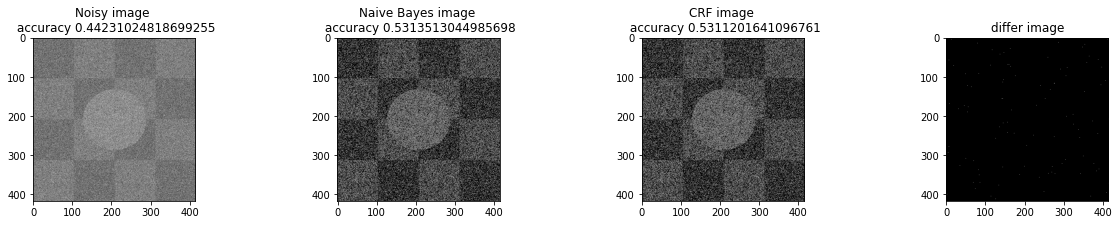

0:00:05.928931


In [1398]:
start_dt = time.time()
deltas, idx, new_classes, energy, changed = a_complete_set_for_part_1(x_arr,
                                                                      max_iter=100,
                                                                      var=1,
                                                                      initial_temp=10,
                                                                      betha=1)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)

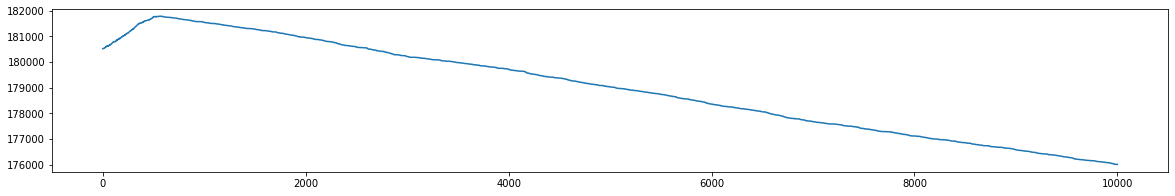

In [905]:
plt.plot(energy1)

current energy: 180520.71304593337


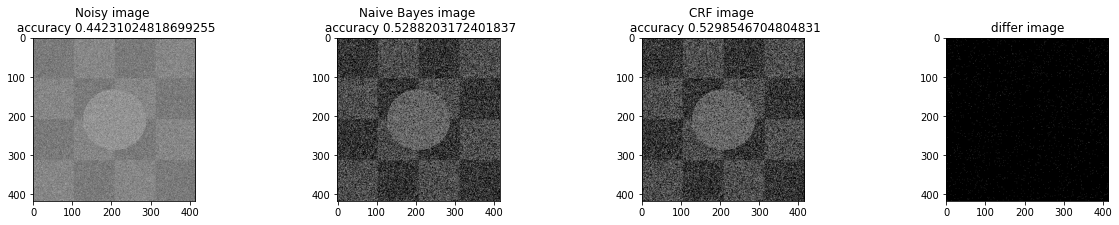

In [904]:
deltas1, idx1, new_classes1, energy1, changed1 = a_complete_set_for_part_1(x_arr,
                                                                      max_iter=1e4,
                                                                      var=1,
                                                                      initial_temp=10,
                                                                      betha=1)
# a_complete_set_for_part_1(x_arr, max_iter=1e4, var=1, betha=1, )

In [897]:
sum(model.changed)

95202

(array([289165., 176224., 125097.,  98184.,  78698.,  64833.,  54289.,
         44033.,  37018.,  32460.]),
 array([-13653.64283695,   5558.3973812 ,  24770.43759935,  43982.4778175 ,
         63194.51803565,  82406.5582538 , 101618.59847195, 120830.6386901 ,
        140042.67890825, 159254.7191264 , 178466.75934455]),
 <a list of 10 Patch objects>)

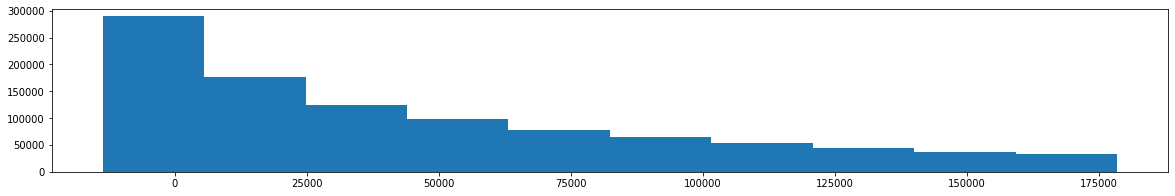

In [901]:
plt.hist(energy)

current energy: 181893.0517083426


/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in double_scalars


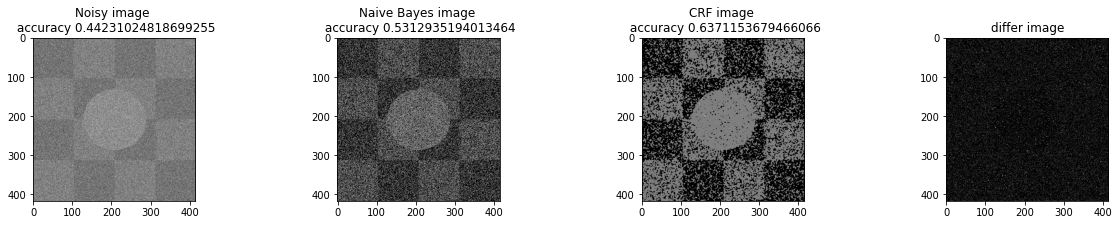

0:00:36.718723


In [914]:
start_dt = time.time()
deltas, idx, new_classes, energy, changed = a_complete_set_for_part_1(x_arr,
                                                                      max_iter=1e6,
                                                                      var=1,
                                                                      initial_temp=10,
                                                                      betha=1)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)
# a_complete_set_for_part_1(x_arr, max_iter=1e6, var=1., betha=1e2)